### 데이터 탐색
Santander Value Prediction Challenge의 목적은   
Predict the value of transactions for potential customers 하는 것이다.  
즉, 거래 내역을 바탕으로 잠재된 고객의 포텐셜한 가치를 예측하는것이다

대회설명만으로 COL에 존재하는 고객들이 기존의 고객인지 아니면 다른 카테고리의 고객인지는 알수 없으나 아니면 고객이 아닐수도 있다. 익명화 되었기 때문에 순전이 데이터 그자체 대해서만 분석해야한다 .이들과의 거래에 따라  ROW에 존재하는 target가 정해진다

자 그럼 데이터를 구경해보자

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline                                                         
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rc('font', family='AppleGothic')
plt.rcParams["figure.figsize"] = (20,4)

In [2]:
train_df = pd.read_csv('train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [3]:
test_df = pd.read_csv('test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [4]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [5]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  첫 탐색
1. 약간 특이한것은 테스트 데이터에 비해 트레인 데이터가 10분의 1로 적다는 것이다. 어떤 의도에서 데이터셋이 이렇게 구성됬는지는 지금 상태에서는 감이 오지 않는다
2. 컬럼이 4991명의 고객과의 트랜잭션 수치이다. 한사람이 이 모두와 거래를 했다는것은 상식적으로 아닐것이라 판단되고 실제로 sparse matrix의 형태를 띄고 있을거라 추측하였다.
3. target의 스케일이 큰것으로 보인다. 실제로 스케일이 클경우 log기반으로 스케일링으로 분산을 줄이는 것이 도움이 될거라 판단이 된다
4. 결론적으로 리그레션 형태의 문제를 푸는것으로 보인다.

### 2번에 대해 확인해보자
1. 먼저 각 컬럼에 대해서 트랜잭션유무를 확인하자 => row에 대해 확인해도 상관없음

In [6]:
id_col_list = train_df.columns.drop(['ID','target'])
id_col_list

Index(['48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00', '2f0771a37',
       '30347e683', 'd08d1fbe3', '6ee66e115', '20aa07010', 'dc5a8f1d8',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4991)

In [7]:
s = train_df[id_col_list[1]].value_counts()
s

0          4455
1196000       1
6000          1
4000000       1
1000000       1
Name: 0deb4b6a8, dtype: int64

In [8]:
zero_list = []
for col in id_col_list:
    number_of_zero = train_df[col].value_counts()[0] 
    zero_list.append(number_of_zero)

In [9]:
col_zero_df = pd.DataFrame({'col':id_col_list,'zero':zero_list, 'p_zero': list(map(lambda x:x/len(train_df),zero_list))}).set_index('col')
col_zero_df.head()

,p_zero,zero
col,,
48df886f9,0.991254,4420
0deb4b6a8,0.999103,4455
34b15f335,0.992599,4426
a8cb14b00,0.999551,4457
2f0771a37,0.998879,4454


In [10]:
col_zero_df.describe()

,p_zero,zero
count,4991.000000,4991.000000
mean,0.968541,4318.725706
std,0.047923,213.687891
min,0.649024,2894.000000
25%,0.961651,4288.000000
50%,0.988114,4406.000000
75%,0.997982,4450.000000
max,1.000000,4459.000000


col 별로 거래액을 살펴보면 대부분이 0인것을 알수 있고 row별로 보더라도 전체 메트릭스의 경향은 바뀌지 않을것임  
즉. sparse matrix 의 형태라는것을 확인  
보통 이런경우 feature의 차원을 줄이는것이 일반적인 테크닉이다  
하지만, 테스트 셋에 값이 존재할경우 전체의 거래액 합과같은 feature를 사용한다고하면 필요할수 있기때문에 바로 삭제하지않는다

### 3번 target의 값의 스케일이 커보인다. 를 확인해보자

In [11]:
plt.rcParams["figure.figsize"] = (10,4)
train_df['target'].describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

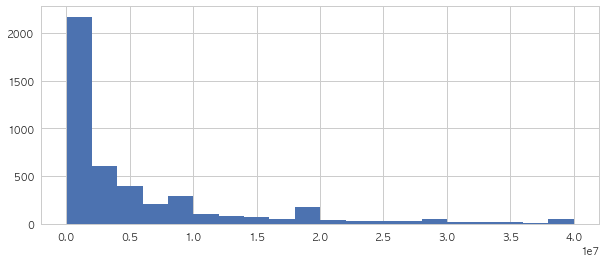

In [12]:
_ = plt.hist(train_df['target'],bins=20)

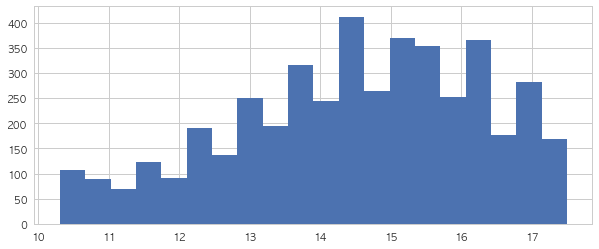

In [14]:
_ = plt.hist(train_df['target'].apply(lambda x:np.log1p(x)),bins=20)

target값의 분포가 왼쪽으로 skewed 되있다. 이에 로그를 취해 정규분포에 가까운 분포로 변형하였다. 변형시의 이점은 일부 metric의 값이 데이터 분포의 형태에 따라 잘못해석될수 있다.

### 4. regression 문제로 접근해보자
우선 regression 문제를 풀기위해선 회귀모형을 만들고 feature들과 target간의 통계치들을 확인하면서 feature를 제거하는 작업을하게 된다.  
먼저, feature들과 target간의 상관분석을 해보자

In [15]:
%%time
coe_list = []
for col in id_col_list:
    coe = train_df[['target',col]].corr().iloc[0,1] 
    coe_list.append(coe)

CPU times: user 4.14 s, sys: 4.99 ms, total: 4.14 s
Wall time: 4.15 s


In [16]:
train_df['log_target'] = train_df['target'].apply(lambda x:np.log1p(x))
log_coe_list = []
for col in id_col_list:
    coe = train_df[['log_target',col]].corr().iloc[0,1] 
    log_coe_list.append(coe)

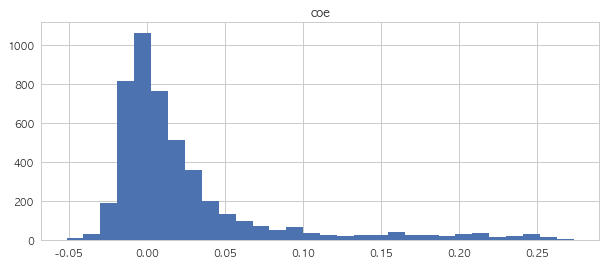

In [17]:
_ = pd.DataFrame({'col':id_col_list,'coe':coe_list}).set_index('col').hist(bins=30)

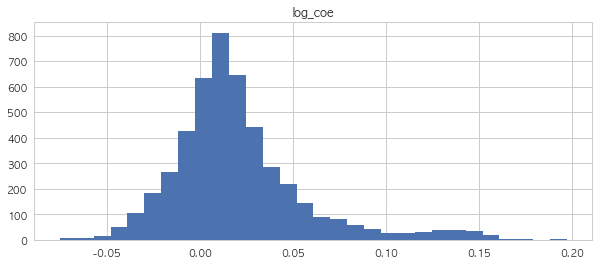

In [18]:
coe_df = pd.DataFrame({'col':id_col_list,'log_coe':log_coe_list}).set_index('col')
_ = coe_df.hist(bins=30)

In [19]:
coe_df.describe()

,log_coe
count,4735.000000
mean,0.020163
std,0.036220
min,-0.075334
25%,-0.000615
50%,0.014176
75%,0.032518
max,0.197227


위와 같이 log 포메이션이 없는 경우에는 아웃라이어에 의해 상관계수가 크게 영향받을수 있음 따라서 log target에 대해 상관계수를 계산한다  
min이 -0.07, max가 0.19로 큰 상관성이 있는 feature들은 보이지않는다.  
이제부터 통계적접근으로 설계하기위해 feature 서로간의 종속성을 분리하고자 feature를 넣고 빼면서 통계치를 확인하여 회귀모델을 설계할수 있지만  
머신러닝 모델을 통해 접근하여보자

# model design
input: transaction value, float  
output: target_value

eval_metric = rmsle
rmsle는 결국 target에 log를 취하고 rmse를 구하는것과 유사함, 0일경우 로그가 inf값이기에 +1처리가 필요

In [20]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [21]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['log_target'],axis=1),cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [22]:
pred = model_rfr.predict(cv_test.drop(['log_target'],axis=1))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.43


현재 1.45의 경우 리더보드에서 2000 / 3600 정도 된다  
나의 목표는 10%안에 들어 동메달을 얻는것이기때문에 좀더 해보도록하자

#### feature scaling
일부 알고리즘의 경우에는 feature스케일링이 필요없지만 빈도가 아닌 metric을 쓰는 알고리즘들은 스케일링에 많은 영향을 받는다 ex)nn, svr

In [23]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
minmax_scaler.fit(train_df.drop(['target','ID','log_target'],axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [24]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [25]:
model_svr = LinearSVR(random_state=10)
model_svr.fit(minmax_scaler.transform(cv_train.drop(['log_target'],axis=1)),cv_train['log_target'])

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=10, tol=0.0001, verbose=0)

In [26]:
pred = model_svr.predict(minmax_scaler.transform(cv_test.drop(['log_target'],axis=1)))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.75


kaggle에는 역시 esemble이 효과가 좋다. 참고로 랜덤포레스트 리그레서는 스케일링한 X라도 결과는 같다

### feature를 추가하여 보자
1. col_sum
2. transaction_num

#### 1. col_sum
고객의 가치는 전체 거래액과 관계가 있을것이라는 가정을 검증해보자

In [27]:
sum_col = 0
for col in train_df.drop(['ID','target','log_target'],axis=1).columns:
    sum_col = sum_col + train_df[col]

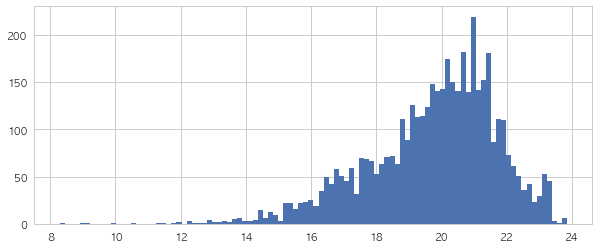

In [28]:
sum_col.apply(lambda x:np.log(x)).hist(bins=100)

In [29]:
train_df['sum_trans'] = sum_col
train_df['log_sum_trans'] = sum_col.apply(lambda x:np.log(x))

In [30]:
train_df[['target','log_target','sum_trans','log_sum_trans']].corr()

,target,log_target,sum_trans,log_sum_trans
target,1.000000,0.761847,0.271884,0.255374
log_target,0.761847,1.000000,0.206092,0.298094
sum_trans,0.271884,0.206092,1.000000,0.636267
log_sum_trans,0.255374,0.298094,0.636267,1.000000


In [31]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [32]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['log_target'],axis=1),cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [33]:
pred = model_rfr.predict(cv_test.drop(['log_target'],axis=1))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.42


1.43 -> 1.42 로 약간 감소하였다. 의미가 없진 않은것으로 판단

In [34]:
importances = model_rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

Feature ranking:


0. feature 4991 (0.061052)
1. feature 4992 (0.060934)
2. feature 4358 (0.044884)
3. feature 2500 (0.013328)
4. feature 3660 (0.010150)
5. feature 1797 (0.008029)
6. feature 4084 (0.007963)
7. feature 572 (0.007070)
8. feature 4758 (0.006051)
9. feature 1427 (0.005418)


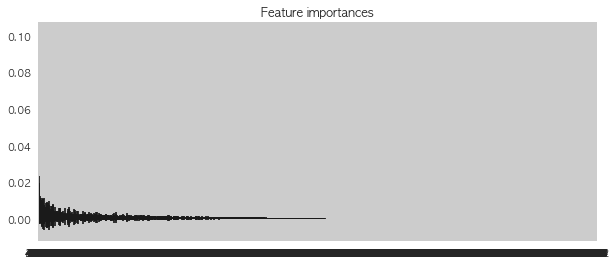

In [35]:
X = cv_train.drop(['log_target'],axis=1)
for f in range(10):
    print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [36]:
X.iloc[:,4991].name

'sum_trans'

In [37]:
X.iloc[:,4992].name

'log_sum_trans'

Feature importance를 확인하였을때 sum_trans 와 log_sum_trans를 각각 상위에 랭크되었다. 의미가 있는 feature로 판단

#### 2. the number of transaction 
일반적으로 고객의 가치는 자주 트레이딩하는것에 영향을 받을것이다. 라는 가정을 검증해보자

In [38]:
value = train_df.drop(['ID','target','log_target','sum_trans','log_sum_trans'],axis=1)
train_df['number_of_trans'] = value.apply(lambda row: np.sum([1 for col in row if col > 0]),axis=1)
train_df['number_of_trans'].head()

0    102
1     67
2     18
3     22
4     26
Name: number_of_trans, dtype: int64

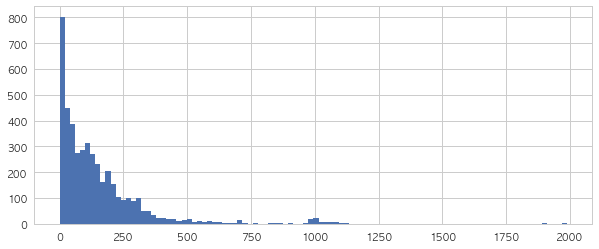

In [39]:
_ = train_df['number_of_trans'].hist(bins=100)

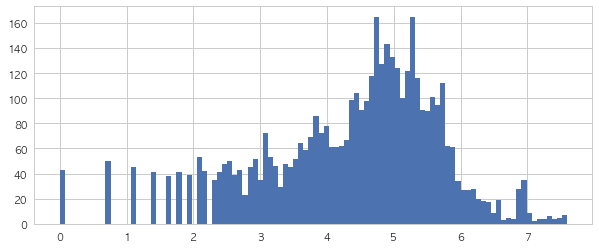

In [40]:
train_df['log_number_of_trans'] = train_df['number_of_trans'].apply(lambda x:np.log(x))
_ = train_df['log_number_of_trans'].hist(bins=100)

In [41]:
train_df[['target','log_target','number_of_trans','log_number_of_trans']].corr()

,target,log_target,number_of_trans,log_number_of_trans
target,1.000000,0.761847,-0.050072,-0.049398
log_target,0.761847,1.000000,-0.050515,-0.058982
number_of_trans,-0.050072,-0.050515,1.000000,0.701890
log_number_of_trans,-0.049398,-0.058982,0.701890,1.000000


일단 직접적인 상관관계는 없다고 판단되나 XOR관계가 있을수 있음으로 학습후 feature importance까지 확인해본다

In [42]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [43]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['log_target'],axis=1),cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [44]:
pred = model_rfr.predict(cv_test.drop(['log_target'],axis=1))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.39


1.42 -> 1.39 로 감소하였다. 의미가 있는 feature

In [45]:
importances = model_rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

Feature ranking:


0. feature 4991 (0.091787)
1. feature 4992 (0.068645)
2. feature 4993 (0.055680)
3. feature 4994 (0.051326)
4. feature 4358 (0.039616)
5. feature 2500 (0.009574)
6. feature 3660 (0.007323)
7. feature 4251 (0.006370)
8. feature 1797 (0.004978)
9. feature 3771 (0.004551)


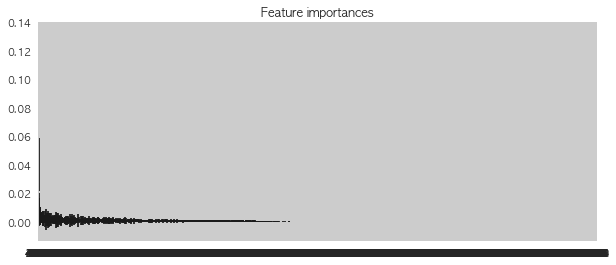

In [46]:
X = cv_train.drop(['log_target'],axis=1)
for f in range(10):
    print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [47]:
print(X.iloc[:,4735].name, X.iloc[:,4736].name, X.iloc[:,4737].name, X.iloc[:,4738].name, X.iloc[:,4135].name)

82e9efdd8 3e3ea106e ae846f332 7bddf55e1 e62cdafcf


#### Feature importance를 확인했을 때, 개인의 트랜스액션 수와 거래액은 포텐셜한 가치(Target)과 중요한 연관이 있음을 알수 있었다
또한, spasre한 데이터이기에 차원축소가 필요함을 인지하고 있었는데 feature importance가 거의 없는 feature가 존재함을 실제로 확인

### 차원을 축소해보자
데이터의 차원을 줄이는 데는 특징 선택(feature selection)과 특징 추출 (feature extraction) 두 가지 방법이 있다

### 1. feature를 selectoin
왜하는가라고 간단히 질문하면
1. computational advantage를 얻을수 있고
2. removing noise, overfit하지 않도록
3. feature가 적을 수록 사람이 이해하기 쉬워짐

 * 처음 생각해볼수 있는 것은 아무와도 거래가 없었던 컬럼을 삭제하는것임

In [48]:
col_zero_df[col_zero_df['p_zero']==1].index

Index(['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee',
       '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca',
       ...
       'd196ca1fd', 'a8e562e8e', 'eb6bb7ce1', '5beff147e', '52b347cdc',
       '4600aadcf', '6fa0b9dab', '43d70cc4d', '408021ef8', 'e29d22b59'],
      dtype='object', name='col', length=256)

In [49]:
drop_col_list = col_zero_df[col_zero_df['p_zero']==1].index.tolist()

In [50]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID']+drop_col_list,axis=1),test_size=0.2,random_state=10)

In [51]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['log_target'],axis=1),cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [52]:
pred = model_rfr.predict(cv_test.drop(['log_target'],axis=1))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.39


zero분포를 가진 col을 빼더라도 성능은 변화가 없었따 rfr 알고리즘에서 내부적으로 처리가 되는듯한 느낌

* feature selection method를 사용해보자
 1. linear 모델에는 weight가 해당 feature의 coefficient로 feature의 중요도를 나타낼수 있다.  
 2. tree모델에서도 feature importance api를 이용해 info gain기반의 metric으로 계산된 중요도를 확인가능
 
 상위 feature 2000개부터 200개까지 이용해보자

In [53]:
important_cols = X.iloc[:,indices].columns
important_cols[:10]

Index(['sum_trans', 'log_sum_trans', 'number_of_trans', 'log_number_of_trans',
       'f190486d6', '58e2e02e6', 'eeb9cd3aa', '5c6487af1', '2ec5b290f',
       '58232a6fb'],
      dtype='object')

In [54]:
cv_train, cv_test = train_test_split(train_df.drop(['log_target','ID'],axis=1),test_size=0.2,random_state=10)

In [158]:
%%time
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['target'],axis=1)[important_cols[:2000]],cv_train['target'])

CPU times: user 4min 57s, sys: 2.38 s, total: 5min
Wall time: 1min 18s


In [159]:
pred = model_rfr.predict(cv_test.drop(['target'],axis=1)[important_cols[:2000]])
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['target'])**2)))

RMSE: 7138313.04


In [160]:
%%time
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['target'],axis=1)[important_cols[:1000]],cv_train['target'])

CPU times: user 3min 5s, sys: 1.61 s, total: 3min 6s
Wall time: 48.8 s


In [161]:
pred = model_rfr.predict(cv_test.drop(['target'],axis=1)[important_cols[:1000]])
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['target'])**2)))

RMSE: 7091004.30


In [162]:
%%time
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['target'],axis=1)[important_cols[:200]],cv_train['target'])

CPU times: user 1min 43s, sys: 2.93 s, total: 1min 46s
Wall time: 1min 25s


In [163]:
pred = model_rfr.predict(cv_test.drop(['target'],axis=1)[important_cols[:200]])
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['target'])**2)))

RMSE: 7095347.89


상위 feature를 200개 까지 줄였을때도 성능은 유지하면서 36s -> 4s까지 9배로 빨라짐   
성능이 아닌 계산효율성향상이 무슨이득이냐고 생각할수 있지만 hyper parameter search시 이득이있다.

### 2. feature extraction
기존에 feature에서 추출하여 보자  
PCA를 적용하여보자

In [83]:
pca = PCA(n_components=2000)
pca.fit(train_df.drop(['target','ID','log_target'],axis=1))

PCA(copy=True, iterated_power='auto', n_components=2000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [84]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [85]:
%%time
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(pca.transform(cv_train.drop(['log_target'],axis=1)),cv_train['log_target'])

CPU times: user 7min 49s, sys: 1.15 s, total: 7min 51s
Wall time: 2min


In [86]:
pred = model_rfr.predict(pca.transform(cv_test.drop(['log_target'],axis=1)))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.55


 성능이 오히려 좋아지지 않았다. feature간의 관계가 non-linear하다는 판단이되었다. corr이 낮은 num_trans를 넣었을때 성능이 향상한것도 근거
 
 feature extraction 관련  1d conv를 이용하여 해볼수 있으나 시퀀스정보가 있는지 없는지 알수 없어 다음에 시도하기로 하였다.

### Hyper parameter tunning

feature를 selection한상태에서 tunning을 하여보자

In [107]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [108]:
parameters = {'n_estimators':[1000,1500,2000]}

In [109]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
clf = GridSearchCV(model_rfr, parameters)

In [110]:
%%time
clf.fit(cv_train.drop(['log_target'],axis=1)[important_cols[:200]],cv_train['log_target'])

CPU times: user 23min 4s, sys: 5.29 s, total: 23min 9s
Wall time: 5min 59s


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000, 1500, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [118]:
print(clf.best_params_, clf.best_score_)

{'n_estimators': 1500} 0.351187698255


In [116]:
best_rfr = RandomForestRegressor(n_estimators=1500, n_jobs=4,random_state=10)
best_rfr.fit(cv_train.drop(['log_target'],axis=1)[important_cols[:200]],cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1500, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [117]:
pred = best_rfr.predict(cv_test.drop(['log_target'],axis=1)[important_cols[:200]])
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.39


tunning을 한후에 성능차이가 없어보이는데 사실 튜닝에서의 성능차이는 1~2%의 작은부분이기때문에 크게변하지 않을수 있음  
튜닝할때는 estimator부터 ~ 레귤러라이저까지 하나식 고정해서 서칭을 하면된다. (combination이 비효울성떄문에)

###  제출을 해보도록 하자

In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [56]:
sum_col = 0
for col in test_df.drop(['ID'],axis=1).columns:
    sum_col = sum_col + test_df[col]

In [57]:
test_df['sum_trans'] = sum_col
test_df['log_sum_trans'] = sum_col.apply(lambda x:np.log1p(x))

In [58]:
%%time
value = test_df.drop(['ID','sum_trans','log_sum_trans'],axis=1)
test_df['number_of_trans'] = value.apply(lambda row: np.sum([1 for col in row if col > 0]),axis=1)
test_df['number_of_trans'].head()

CPU times: user 55.9 s, sys: 3.71 s, total: 59.6 s
Wall time: 1min


In [59]:
test_df['log_number_of_trans'] = test_df['number_of_trans'].apply(lambda x:np.log(x))

### 베이스라인 모델학습

In [84]:
best_rfr = RandomForestRegressor(n_estimators=1500, n_jobs=4,random_state=10)
best_rfr.fit(train_df.drop(['ID','target','log_target'],axis=1)[important_cols[:]],train_df['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1500, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [ ]:
pred = best_rfr.predict(test_df.drop(['ID'],axis=1)[important_cols[:]])
test_df['log_target'] = pred
test_df['target'] = test_df['log_target'].apply(lambda x:np.expm1(x)).astype(int)

In [83]:
test_df[['ID','target']].head()

,ID,target
0,000137c73,269246
1,00021489f,269246
2,0004d7953,761415
3,00056a333,3354216
4,00056d8eb,269246


In [81]:
test_df[['ID','target']].to_csv('submission1.csv',index=False)